In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from datetime import datetime
import seaborn as sns
import yfinance as yf
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy, RootMeanSquaredError
%matplotlib inline

In [15]:
def get_stock_data(stock_name):
    data = yf.Ticker(stock_name)
    df = data.history(period='20y')
    cols = list(df.columns)
    if 'Dividends' in cols:
        df = df.drop('Dividends', axis=1)
    if 'Stock Splits' in cols:
        df = df.drop('Stock Splits', axis=1)
    df.reset_index(drop=True, inplace=True)
    return df

In [16]:
df=get_stock_data('META')

In [17]:
df

,Open,High,Low,Close,Volume
0,42.049999,45.000000,38.000000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,50237200
...,...,...,...,...,...
2687,141.690002,145.000000,141.360001,143.139999,21970200
2688,141.220001,143.169998,140.309998,141.500000,26622000
2689,144.399994,147.509995,143.300003,147.300003,25482100
2690,148.240005,153.190002,147.389999,151.740005,35746900


In [18]:
def create_datasets(df, window_size=100):
    x=[]
    y=[]
    
    for i in range(1, len(df)-window_size-1, 1):
        first = df.iloc[i, 3] 
        temp=[]
        temp2=[]
        for j in range(window_size):
            temp.append((df.iloc[i+j, 3]-first)/first)
        temp2.append((df.iloc[i+window_size, 3]-first)/first)
        x.append(np.array(temp).reshape(100, 1))
        y.append(np.array(temp2).reshape(1,1))
        
    return x,y

In [22]:
(df.iloc[2,3]-df.iloc[1,3])/df.iloc[1,3]

-0.08903905048448787

In [23]:
(df.iloc[101,3]-df.iloc[1,3])/df.iloc[1,3]

-0.41962971764737533

In [27]:
x,y=create_datasets(df)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True)

In [30]:
train_x=np.array(x_train)
train_y=np.array(y_train)
test_x=np.array(x_test)
test_y=np.array(y_test)

In [72]:
train_x = train_x.reshape(train_x.shape[0], 1, 100, 1)
test_x = test_x.reshape(test_x.shape[0], 1, 100, 1)

In [73]:
model = tf.keras.Sequential()
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(3)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(3)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(3)))
model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
#     model = Sequential()
#     model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(None, 100, 1))))
#     model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#     model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation="relu")))
#     model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#     model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation="relu")))
#     model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#     model.add(TimeDistributed(Flatten()))
              
#     model.add(Bidirectional(LSTM(100, return_sequences=True)))
#     model.add(Dropout(0.5))
#     model.add(Bidirectional(LSTM(100, return_sequences=False)))
#     model.add(Dropout(0.5))
# #     model.add(Dense(1))
# #     model = Sequential()
# #     model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
# #     model.add(TimeDistributed(MaxPooling1D(2)))
# #     model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
# #     model.add(TimeDistributed(MaxPooling1D(2)))
# #     model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
# #     model.add(TimeDistributed(MaxPooling1D(2)))
# #     model.add(TimeDistributed(Flatten()))

# #     model.add(Bidirectional(LSTM(100, return_sequences=True)))
# #     model.add(Dropout(0.5))
# #     model.add(Bidirectional(LSTM(100, return_sequences=False)))
# #     model.add(Dropout(0.5))
# #     model.add(Dense(1))
#     return model

In [74]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=50, verbose=1, shuffle=True)

Epoch 1/50
42/42 [==============================] - 14s 74ms/step - loss: 0.0595 - mse: 0.0595 - mae: 0.1752 - val_loss: 0.0371 - val_mse: 0.0371 - val_mae: 0.1362
Epoch 2/50
42/42 [==============================] - 1s 15ms/step - loss: 0.0454 - mse: 0.0454 - mae: 0.1519 - val_loss: 0.0349 - val_mse: 0.0349 - val_mae: 0.1358
Epoch 3/50
42/42 [==============================] - 1s 15ms/step - loss: 0.0421 - mse: 0.0421 - mae: 0.1431 - val_loss: 0.0331 - val_mse: 0.0331 - val_mae: 0.1328
Epoch 4/50
42/42 [==============================] - 1s 15ms/step - loss: 0.0415 - mse: 0.0415 - mae: 0.1409 - val_loss: 0.0270 - val_mse: 0.0270 - val_mae: 0.1172
Epoch 5/50
42/42 [==============================] - 1s 15ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1375 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.1231
Epoch 6/50
42/42 [==============================] - 1s 15ms/step - loss: 0.0403 - mse: 0.0403 - mae: 0.1368 - val_loss: 0.0292 - val_mse: 0.0292 - val_mae: 0.1240
Epoch 7/50
42/42 [===

In [75]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_70 (TimeDi  (None, 1, 98, 64)        256       
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 1, 32, 64)        0         
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 1, 30, 128)       24704     
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, 1, 10, 128)       0         
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 1, 8, 64)       

In [76]:
model.evaluate(test_x, test_y)

17/17 [==============================] - 0s 5ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1064


[0.021489936858415604, 0.021489936858415604, 0.1064261719584465]

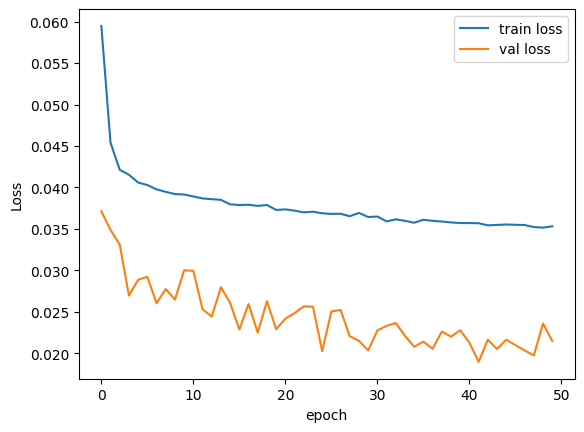

In [77]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

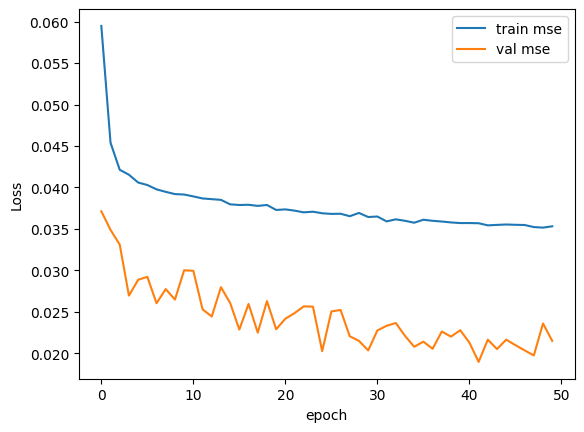

In [78]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [79]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_x, verbose=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

17/17 [==============================] - 2s 3ms/step
Variance: 0.694176
R2 Score: 0.694176
Max Error: 0.682332


### Trying out value prediction

In [80]:
model = Sequential()
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1))

In [82]:
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [83]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=50, verbose=1, shuffle=True)

Epoch 1/50
42/42 [==============================] - 9s 55ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1046 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0704
Epoch 2/50
42/42 [==============================] - 1s 24ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0709 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0600
Epoch 3/50
42/42 [==============================] - 1s 24ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0627 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0678
Epoch 4/50
42/42 [==============================] - 1s 24ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0586 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0539
Epoch 5/50
42/42 [==============================] - 1s 24ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0577 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0558
Epoch 6/50
42/42 [==============================] - 1s 23ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0580 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0580
Epoch 7/50
42/42 [====

In [84]:
model.evaluate(test_x, test_y)

17/17 [==============================] - 0s 7ms/step - loss: 0.0035 - mse: 0.0035 - mae: 0.0431


[0.003508817171677947, 0.003508817171677947, 0.043086275458335876]

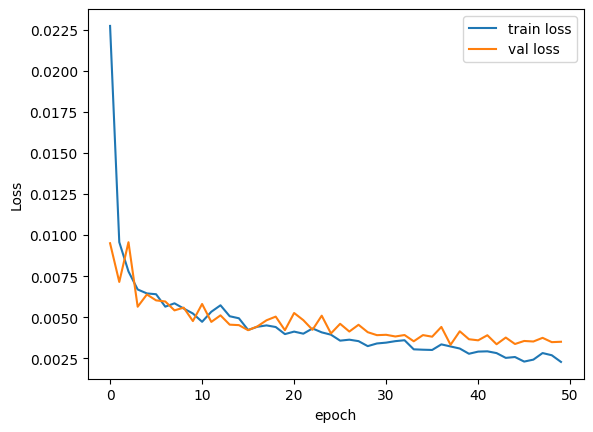

In [85]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

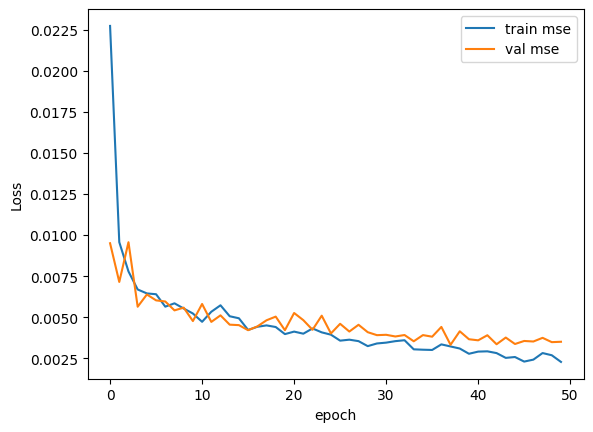

In [86]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [101]:
# model.predict([42,45,38,5752415])
pred = np.array([42,45,38,45,5752415])

In [102]:
pred=pred.reshape(pred.shape[0], 1, 100, 1)

ValueError: cannot reshape array of size 5 into shape (5,1,100,1)

In [107]:
model.predict(test_x)[0][0]

17/17 [==============================] - 0s 5ms/step


-0.04733753

In [109]:
test_x[0][0][0]

array([-0.01915854])

In [153]:
pred_y=model.predict(test_x)

17/17 [==============================] - 16s 361ms/step


In [152]:
test_y

array([[[-9.54170111e-02]],

       [[-2.60603474e-02]],

       [[-4.99114990e-02]],

       [[ 2.14630628e-01]],

       [[ 1.82440155e-01]],

       [[-2.52873537e-01]],

       [[-6.53522836e-02]],

       [[ 3.92997035e-01]],

       [[ 7.40302022e-02]],

       [[ 1.10452651e-01]],

       [[ 3.81803367e-02]],

       [[ 8.75477611e-02]],

       [[ 3.24625442e-01]],

       [[ 2.06932093e-01]],

       [[ 6.68221170e-02]],

       [[ 6.33021709e-02]],

       [[-2.37659380e-01]],

       [[ 2.41840101e-01]],

       [[ 6.44070774e-02]],

       [[ 1.99701152e-01]],

       [[ 9.62666829e-02]],

       [[ 2.18939598e-02]],

       [[ 6.77839590e-03]],

       [[ 1.76557440e-02]],

       [[ 3.74490269e-02]],

       [[ 1.15645670e-01]],

       [[-3.71126571e-01]],

       [[ 4.41812062e-01]],

       [[-5.62068676e-02]],

       [[ 1.13757962e-01]],

       [[ 2.02662049e-01]],

       [[ 6.87568370e-01]],

       [[-1.86573518e-01]],

       [[-3.17390342e-02]],

       [[ 6.45

In [117]:
df.head()

,Open,High,Low,Close,Volume
0,42.049999,45.000000,38.000000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,50237200


In [122]:
(df.iloc[3,3]-df.iloc[1,3])/df.iloc[1,3]

-0.059653213403342314

In [142]:

xx=[]
yy=[]
window_size=2
for i in range(1, len(small_df)-window_size-1, 1):
    first = df.iloc[i, 3] 
    temp=[]
    temp2=[]
    for j in range(window_size):
        temp.append((df.iloc[i+j, 3]-first)/first)
    temp2.append((df.iloc[i+window_size, 3]-first)/first)
    xx.append(np.array(temp).reshape(window_size, 1))
    yy.append(np.array(temp2).reshape(1,1))

In [143]:
small_df=df[:10]

In [148]:
(small_df.iloc[2,3]-small_df.iloc[1,3])/small_df.iloc[1,3]

-0.08903905048448787

In [144]:
xx

[array([[ 0.        ],
        [-0.08903905]]),
 array([[0.        ],
        [0.03225806]]),
 array([[0.        ],
        [0.03218746]]),
 array([[ 0.        ],
        [-0.03390854]]),
 array([[ 0.        ],
        [-0.09620808]]),
 array([[ 0.        ],
        [-0.02253813]])]

In [145]:
yy

[array([[-0.05965321]]),
 array([[0.06548383]]),
 array([[-0.0028125]]),
 array([[-0.12685434]]),
 array([[-0.11657785]]),
 array([[0.0263523]])]

In [154]:
from sklearn.metrics import accuracy_score

In [137]:
temp

[0.0, -0.022538128123828986]

In [138]:
temp2

[0.026352296285048357]

In [155]:
accuracy_score(test_y, pred_y)

ValueError: Classification metrics can't handle a mix of unknown and continuous targets

In [192]:
test_y=np.array(test_y)

In [161]:
pred_y.shape = pred_y.reshape(pred_y[0],1,1)

TypeError: only integer scalar arrays can be converted to a scalar index

In [163]:
test_y.shape

(518, 1, 1)

In [166]:
pred_y=np.array(pred_y)

In [168]:
test_y=test_y.reshape(test_y.shape[0], 1)

In [169]:
test_y.shape, pred_y.shape

((518, 1), (518, 1))

In [180]:
c=[]
for x in range(len(test_y)):
    c.append(abs(test_y[x]-pred_y[x]))

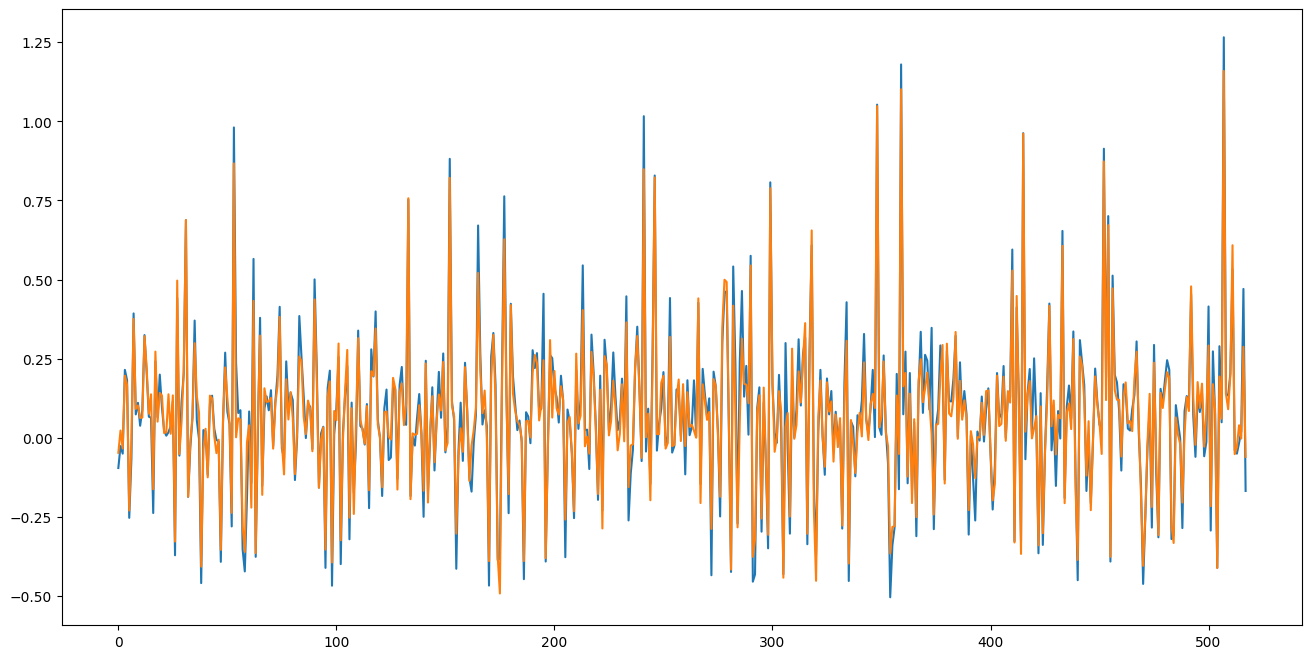

In [188]:
plt.figure(figsize=(16,8))
plt.plot(list(range(len(test_y))), test_y)
plt.plot(list(range(len(test_y))), pred_y)

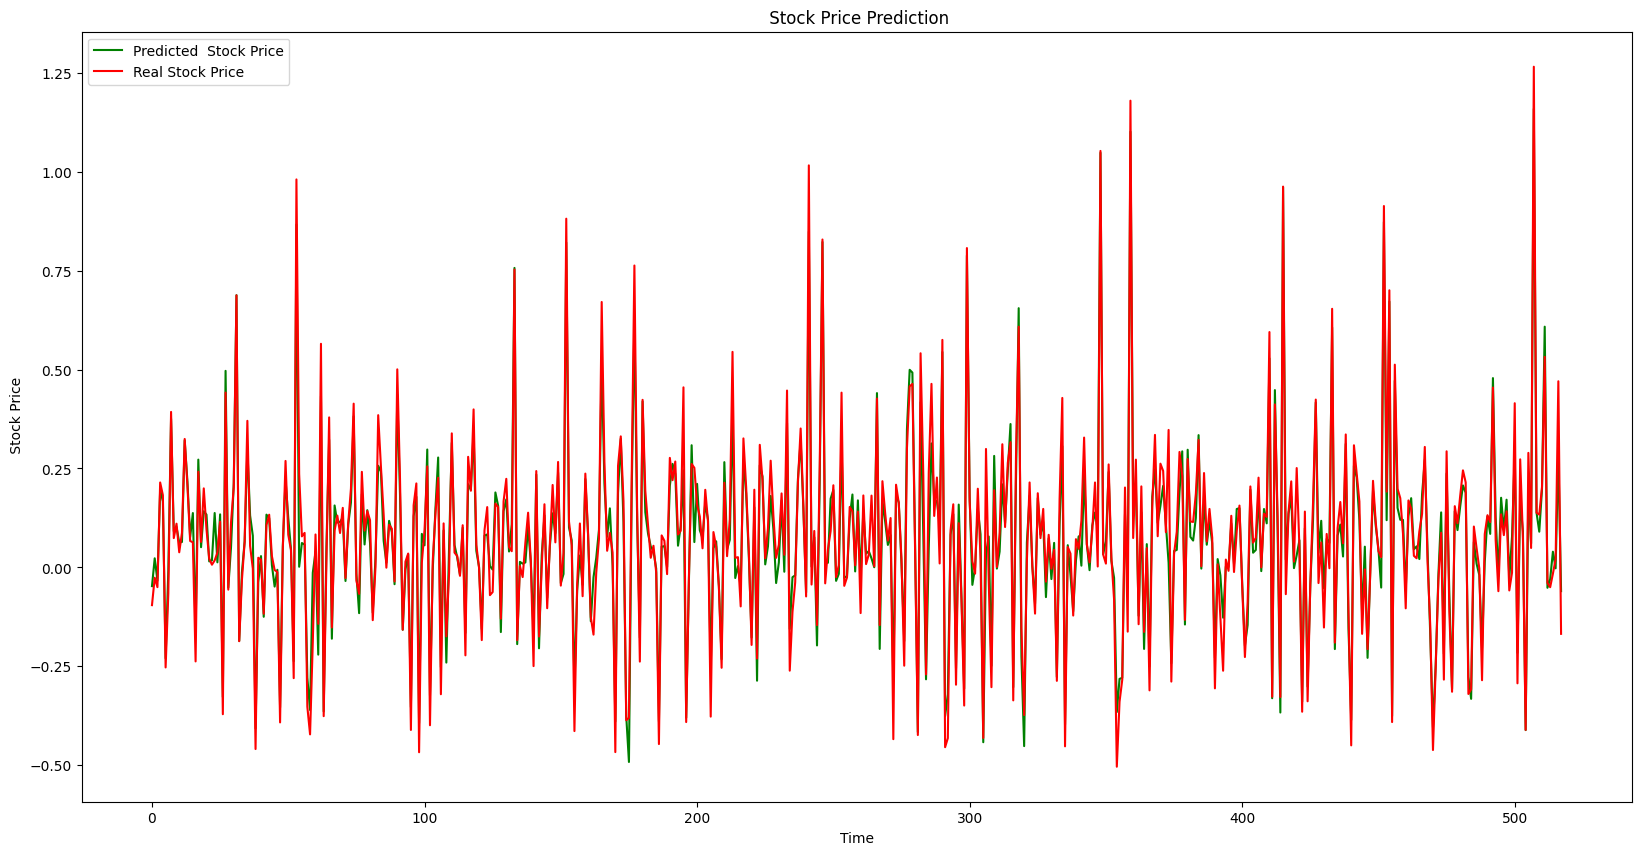

In [193]:
plt.figure(figsize=(20,10))
plt.plot(pred_y, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_y, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [194]:
df

,Open,High,Low,Close,Volume
0,42.049999,45.000000,38.000000,38.230000,573576400
1,36.529999,36.660000,33.000000,34.029999,168192700
2,32.610001,33.590000,30.940001,31.000000,101786600
3,31.370001,32.500000,31.360001,32.000000,73600000
4,32.950001,33.209999,31.770000,33.029999,50237200
...,...,...,...,...,...
2687,141.690002,145.000000,141.360001,143.139999,21970200
2688,141.220001,143.169998,140.309998,141.500000,26622000
2689,144.399994,147.509995,143.300003,147.300003,25482100
2690,148.240005,153.190002,147.389999,151.740005,35746900


In [195]:
def inverse_normalization(df, normalized_values, window_size=100):
    first = df.iloc[i, 3]
    original_values = (normalized_values + 1) * first
    return original_values

In [200]:
pred_y=inverse_normalization(df, pred_y)

In [202]:
test_y=inverse_normalization(df, test_y)

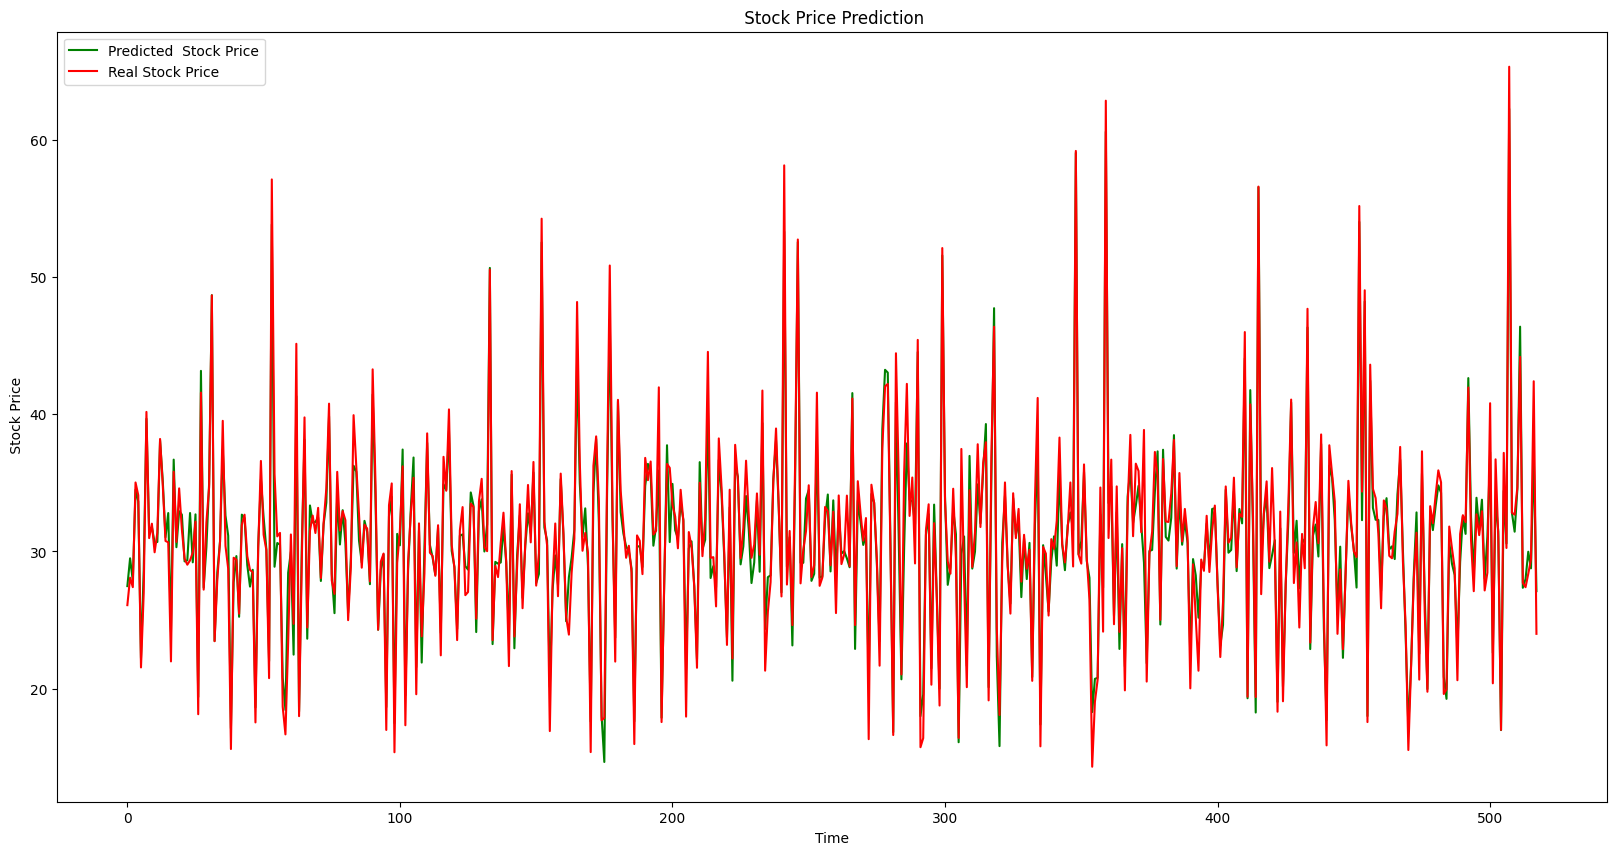

In [203]:
plt.figure(figsize=(20,10))
plt.plot(pred_y, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_y, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

https://towardsdatascience.com/using-deep-learning-ai-to-predict-the-stock-market-9399cf15a312